In [23]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [3]:
df_dev = pd.read_csv('dataset/development.csv')
df_eval = pd.read_csv('dataset/evaluation.csv')

df = pd.concat([df_dev, df_eval], sort=False)
df.head()

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,...,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00,2900.0,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,...,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00,1300.0,tech,thursday
2,2,http://mashable.com/2013/10/30/digital-dinosau...,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,...,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00,17700.0,lifestyle,wednesday
3,3,http://mashable.com/2014/08/27/homer-simpson-i...,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,...,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25,1500.0,bus,wednesday
4,4,http://mashable.com/2013/01/10/creepy-robotic-...,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,...,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10,1400.0,tech,thursday


## Categorical data

### OneHot Encoding
- OneHot Encoding generates redundant data: if the ml model requires too much time to train itself or the model overfits, then the Effect Coding or Dummy Encoding could help to reduce the number of features.

In [4]:
enc = OneHotEncoder()
encoded_df = pd.concat([df_dev['weekday'], df_dev['data_channel']], axis=1)
enc.fit(encoded_df)
encoded_df = enc.transform(encoded_df)
additional_columns = enc.get_feature_names_out()
print(encoded_df.toarray().shape)
working_df_dev = df_dev.copy()
working_df_dev[additional_columns] = encoded_df.toarray()
working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)
working_df_dev

(31715, 13)


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world
0,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,33.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,4.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,0.0,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,37.0,11.0,440.0,0.564103,1.0,0.718978,10.0,2.0,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31711,52.0,14.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31712,121.0,9.0,969.0,0.489583,1.0,0.710623,6.0,5.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31713,503.0,11.0,1976.0,0.412308,1.0,0.621080,21.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Numerical data

### Feature selection based on correlation
- Features to delete (look at multivariate analysis):
    - n_unique_tokens
    - n_non_stop_words
    - kw_max_min
    - kw_min_max
    - kw_max_avg
    - abs_title_sentiment_polarity
    - abs_title_subjectivity
    - rate_positive_words 
    - timedelta
    - max_negative_polarity
    - min_negative_polarity
    - kw_min_min
    - kw_max_max
    - num_self_hrefs
    - n_tokens_content (to be verified)
    - data_channel_business
    - LDA_00

In [5]:
working_df_dev.drop(columns=['n_unique_tokens','n_non_stop_words','kw_max_min','kw_min_max','kw_max_avg','abs_title_sentiment_polarity',
                     'abs_title_subjectivity','rate_positive_words','timedelta','max_negative_polarity','min_negative_polarity',
                     'kw_min_min','kw_max_max','num_self_hrefs','data_channel_bus','LDA_00'], inplace=True)

In [6]:
working_df_dev.head()

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world
0,12.0,1015.0,0.545031,10.0,33.0,1.0,4.656158,4.0,110.500000,398350.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,503.0,0.737542,9.0,NaN,1.0,4.576541,10.0,524.750000,117960.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.0,232.0,0.748428,12.0,4.0,1.0,4.935345,6.0,198.666667,573878.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,12.0,171.0,0.867925,9.0,0.0,NaN,4.970760,6.0,444.166667,311033.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,11.0,286.0,0.800000,5.0,NaN,0.0,5.006993,NaN,356.200000,6830.125000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature selection based on univariate analysis
- Features to delete:
    - n_tokens_content: It can be observed that there are a lot of values equal to 0 words: this can be due to an error during the data collection step. As solution, we decide to drop the records corresponding to the value zero of this feature (3% of the whole dataset)
- Features to transform:
    - num_imgs: Filled NaN values with 0 and rescaled in logarithmic scale to better distribute data and remove outliers.
    - num_videos: Filled NaN values with 0 and rescaled in logarithmic scale to better distribute data and remove outliers.
    - n_tokens_content: Rescaled in logarithmic scale to better distribute data and remove outliers
    - avg_negative_polarity: Use absolute value to bring the range of this feature between [0, +1] as the corresponding "avg_positive_polarity" features
    - num_keywords: Filled NaN values with 0
    - num_hrefs: Rescaled in logarithmic scale to better distribute data
    - shares: Rescaled in logarithmic scale to better distribute data
- Features to scale:
    - n_tokens_content: standard scaler
    - n_tokens_title: standard scaler
    - kw_avg_min: standard scaler
    - kw_avg_max: standard scaler
    - kw_min_avg: standard scaler
    - kw_avg_avg: standard scaler
    - self_reference_min_shares: standard scaler
    - self_reference_max_shares: standard scaler
    - self_reference_avg_sharess: standard scaler
    


In [7]:
working_df_dev = working_df_dev.query("n_tokens_content > 0")

In [8]:
working_df_dev['n_tokens_content'] = np.log(working_df_dev['n_tokens_content'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/420597367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['n_tokens_content'] = np.log(working_df_dev['n_tokens_content'])


In [9]:
working_df_dev['num_imgs'].fillna(0, inplace=True)
working_df_dev['num_imgs'] = np.log(1+working_df_dev['num_imgs'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/4188442937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_imgs'].fillna(0, inplace=True)
/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/4188442937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_imgs'] = np.log(1+working_df_dev['num_imgs'])


In [10]:
working_df_dev['num_videos'].fillna(0, inplace=True)
working_df_dev['num_videos'] = np.log(1+working_df_dev['num_videos'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/1745796961.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_videos'].fillna(0, inplace=True)
/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/1745796961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_videos'] = np.log(1+working_df_dev['num_videos'])


In [11]:
std_scaler = StandardScaler().fit(working_df_dev[['n_tokens_title', 'n_tokens_content']])
scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/1289566745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features


In [12]:
working_df_dev['avg_negative_polarity'] = working_df_dev['avg_negative_polarity'].abs()

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/4135121572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['avg_negative_polarity'] = working_df_dev['avg_negative_polarity'].abs()


In [13]:
working_df_dev['num_keywords'].fillna(0, inplace=True)

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/619483132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_keywords'].fillna(0, inplace=True)


In [14]:
working_df_dev['shares'] = np.log(working_df_dev['shares'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/1159595187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['shares'] = np.log(working_df_dev['shares'])


In [15]:
std_scaler = StandardScaler().fit(working_df_dev[['kw_avg_min', 'kw_avg_max', 'kw_min_avg', 'kw_avg_avg']])
scaled_features = std_scaler.transform(working_df_dev[['kw_avg_min', 'kw_avg_max', 'kw_min_avg', 'kw_avg_avg']])
working_df_dev[['kw_avg_min', 'kw_avg_max', 'kw_min_avg', 'kw_avg_avg']] = scaled_features

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/3702993585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev[['kw_avg_min', 'kw_avg_max', 'kw_min_avg', 'kw_avg_avg']] = scaled_features


In [16]:
std_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/2796675946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features


In [47]:
working_df_dev['num_hrefs'] = np.log(1 + working_df_dev['num_hrefs'])

/var/folders/6w/dmgtk2bn4jx1mdj87jl8c6sh0000gn/T/ipykernel_4868/2945718431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_dev['num_hrefs'] = np.log(1 + working_df_dev['num_hrefs'])


In [72]:
working_df_dev

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,...,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world
0,0.768992,1.182360,0.545031,2.397895,3.526361,0.693147,4.656158,4.0,-0.322607,1.085158,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.649891,0.213789,0.737542,2.302585,0.000000,0.693147,4.576541,10.0,0.340016,-1.040296,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.649891,-0.853837,0.748428,2.564949,1.609438,0.693147,4.935345,6.0,-0.181578,2.415724,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.768992,-1.274725,0.867925,2.302585,0.000000,0.000000,4.970760,6.0,0.211117,0.423268,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.296031,-0.565145,0.800000,1.791759,0.000000,0.000000,5.006993,0.0,0.070408,-1.882699,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31709,0.296031,0.254330,0.703008,2.302585,0.693147,0.693147,4.372587,0.0,0.045028,-0.256184,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31710,0.296031,0.029174,0.718978,2.397895,0.000000,0.000000,4.784091,5.0,-0.142975,0.010189,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
31712,-0.649891,1.118374,0.710623,1.945910,1.098612,0.693147,4.594427,8.0,-0.184777,-0.335967,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
31713,0.296031,2.101447,0.621080,3.091042,0.693147,1.386294,4.353239,10.0,-0.220395,0.156338,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Features importance

### Features selected based on the importance
- Use RandomForestRegression to discover the features importance in order to predict the target variable
- The OneHot-Encoding features have a lower importance... It is possibile to try to delete them
- Without the OneHot-Encoding features the RMSE is higher and this means a worse result

In [55]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [56]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8505755743901013
0.13566296637644382


In [57]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.10718321534454671),
 ('self_reference_avg_sharess', 0.04763424252071392),
 ('kw_avg_max', 0.04508190787816193),
 ('kw_avg_min', 0.04155012853214559),
 ('n_non_stop_unique_tokens', 0.040511365730716314),
 ('n_tokens_content', 0.037690576794624876),
 ('average_token_length', 0.037333533754097946),
 ('global_subjectivity', 0.0356572966283945),
 ('LDA_01', 0.03488211237747165),
 ('LDA_04', 0.03458318850263466),
 ('LDA_02', 0.03442224534978368),
 ('avg_positive_polarity', 0.03436116763334737),
 ('LDA_03', 0.03417230965437211),
 ('avg_negative_polarity', 0.03381988900479984),
 ('self_reference_min_shares', 0.03322810115675969),
 ('global_rate_positive_words', 0.03254864024772804),
 ('global_sentiment_polarity', 0.03182098413163277),
 ('num_hrefs', 0.03161467136939465),
 ('global_rate_negative_words', 0.02904723284586402),
 ('kw_min_avg', 0.027147575394756186),
 ('rate_negative_words', 0.023541698387162132),
 ('self_reference_max_shares', 0.022056661584378495),
 ('title_sent

#### Without OneHot-Encoded features

In [78]:
working_df_dev_no_onehot = working_df_dev.drop(columns=['data_channel_world', 'weekday_friday', 'weekday_wednesday',
                                                        'weekday_thursday', 'data_channel_lifestyle', 'weekday_tuesday',
                                                        'weekday_monday', 'data_channel_socmed', 'weekday_sunday', 'data_channel_tech',
                                                        'data_channel_entertainment', 'weekday_saturday'])

X = working_df_dev_no_onehot.drop(columns=["shares"]).values
y = working_df_dev_no_onehot["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [59]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8559408247375676
0.1247244665434647


In [60]:
feature_names = working_df_dev_no_onehot.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.11044895690775566),
 ('self_reference_avg_sharess', 0.04926776474511304),
 ('kw_avg_max', 0.047355415176575266),
 ('kw_avg_min', 0.04374766267911385),
 ('n_non_stop_unique_tokens', 0.04230917542764838),
 ('LDA_01', 0.03979648738535886),
 ('LDA_04', 0.03946678694668837),
 ('n_tokens_content', 0.03915448765787121),
 ('average_token_length', 0.038543912739106165),
 ('global_subjectivity', 0.038425300204354654),
 ('LDA_02', 0.037130928033989555),
 ('LDA_03', 0.03711095942000228),
 ('avg_positive_polarity', 0.0356730903177886),
 ('avg_negative_polarity', 0.03550492933578567),
 ('self_reference_min_shares', 0.0343583856022983),
 ('global_rate_positive_words', 0.03362383617265644),
 ('global_sentiment_polarity', 0.033298827748174845),
 ('num_hrefs', 0.032537821566620634),
 ('global_rate_negative_words', 0.029827182624030144),
 ('kw_min_avg', 0.029168613010562956),
 ('rate_negative_words', 0.02469459618733489),
 ('self_reference_max_shares', 0.02252662737095779),
 ('title_sen

#### Continue to delete features with low importance

In [79]:
working_df_dev_reducted = working_df_dev_no_onehot.drop(columns=['self_reference_min_shares', 'self_reference_max_shares', 'kw_min_avg', 'kw_avg_avg',
                                                            'min_positive_polarity', 'max_positive_polarity', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'])

X = working_df_dev_reducted.drop(columns=["shares"]).values
y = working_df_dev_reducted["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [81]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8774152875040087
0.08025443770674512


In [77]:
feature_names = working_df_dev_reducted.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('self_reference_avg_sharess', 0.09874496329273745),
 ('kw_avg_max', 0.06308988012270815),
 ('kw_avg_min', 0.0609908405212075),
 ('n_non_stop_unique_tokens', 0.05786302241558468),
 ('average_token_length', 0.057381221043681006),
 ('global_subjectivity', 0.056455306456974864),
 ('n_tokens_content', 0.05554684669724463),
 ('avg_positive_polarity', 0.05353840853426568),
 ('global_rate_positive_words', 0.049381579200996804),
 ('avg_negative_polarity', 0.04915682038521308),
 ('num_hrefs', 0.04658050074205566),
 ('global_sentiment_polarity', 0.04490124003615786),
 ('global_rate_negative_words', 0.04289293018713305),
 ('rate_negative_words', 0.034479842755919754),
 ('title_sentiment_polarity', 0.03058223415713801),
 ('n_tokens_title', 0.029041857796420895),
 ('num_imgs', 0.025904649606108335),
 ('title_subjectivity', 0.0239993375816882),
 ('num_keywords', 0.022454375720673606),
 ('num_videos', 0.014392338823224892),
 ('data_channel_world', 0.013364319186322693),
 ('data_channel_entertainment

### Features selection with PCA
- We just need from 8 to 16 Principal Components (PCs) in order to cover the cumulative explain variance of the dataset

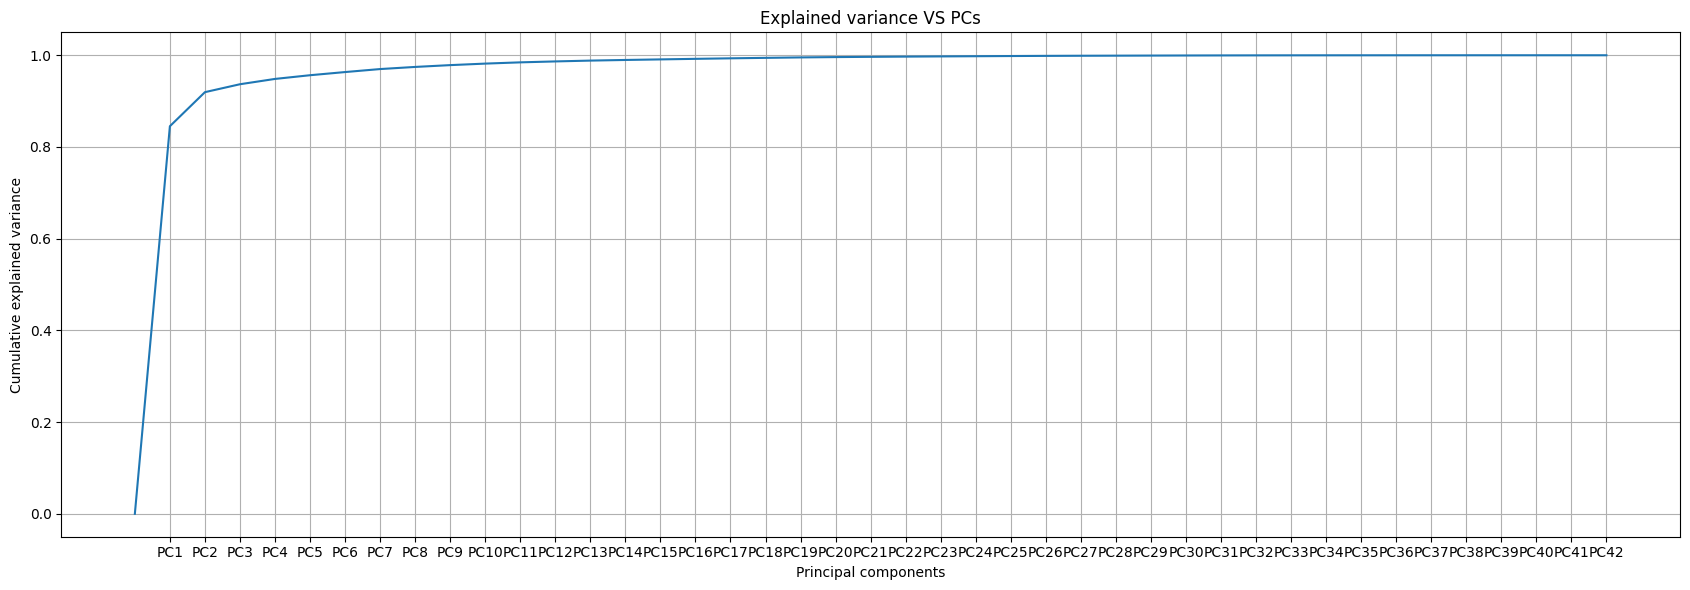

In [31]:
X = working_df_dev.drop(columns=["shares"]).values

pca_1 = PCA(random_state = 42)
pca_1.fit(X)

fig, ax = plt.subplots(1,1, figsize = (17,6))
ax.plot(np.insert(np.cumsum(pca_1.explained_variance_ratio_), 0, 0))
ax.set_title('Explained variance VS PCs')
plt.xticks(ticks=np.arange(1, pca_1.n_features_in_ + 1),
           labels=[f'PC{i}' for i in range(1, pca_1.n_features_in_ + 1)])
ax.set_xlabel('Principal components')
ax.set_ylabel('Cumulative explained variance')
ax.grid()
plt.tight_layout()
plt.show()

In [32]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_12 = PCA(n_components=12, random_state = 42)
pca_12.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_12.transform(X), y, shuffle=True, random_state=42)

In [36]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8688872188329296
0.09804654845413274


In [37]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('n_non_stop_unique_tokens', 0.13454098707910733),
 ('n_tokens_title', 0.09790095070118207),
 ('kw_avg_avg', 0.08935787403970165),
 ('kw_min_avg', 0.08213931339881514),
 ('num_imgs', 0.08126376535984962),
 ('num_videos', 0.08025253501825359),
 ('num_keywords', 0.07564481820096851),
 ('n_tokens_content', 0.07548242160043558),
 ('average_token_length', 0.07449868077618106),
 ('kw_avg_min', 0.07423015669010685),
 ('num_hrefs', 0.06985958281557146),
 ('kw_avg_max', 0.06482891431982697)]

In [39]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_16 = PCA(n_components=16, random_state = 42)
pca_16.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_16.transform(X), y, shuffle=True, random_state=42)
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8606521973872098
0.11506235367672135


## Polynomial regressor (as Beppe wants)

In [68]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [69]:
poli = PolynomialFeatures(2)
poli_train = poli.fit_transform(X_train)
poli_test = poli.fit_transform(X_valid)

reg = LinearRegression()
reg.fit(poli_train, y_train)
preds_poli_reg = reg.predict(poli_test)

rms = mean_squared_error(y_valid, preds_poli_reg, squared=False)
print(rms)
print(r2_score(y_valid, preds_poli_reg))

0.8878377020889384
0.05827418873559209
